In [2]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor

In [3]:
def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt = []
    
    c2pt_start = 9
    c3pt_start = 10155
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
#                                     if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                    elif i > 10217:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt

ts, taus, xs, ys, zs, c2pt, c3pt = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(2):
        c2pt[i][j] /= N_factor
        c3pt[i][j] /= N_factor
c2pt = np.array(c2pt)
c3pt = np.array(c3pt)

## Prediction of c3pt based on c2pt directly

In [4]:
features_raw = np.array([np.append([ts[i], taus[i]], [c2pt[(i//64) * 64:(i//64+1) * 64, 0], c2pt[(i//64) * 64:(i//64+1) * 64, 1]]) for i in range(len(ts))])
labels_raw = np.array([np.array([c3pt[i][0], c3pt[i][1]]) for i in range(len(c3pt))])

s = np.arange(len(features_raw))
np.random.shuffle(s)
features = features_raw[s]
labels = labels_raw[s]

data_points = len(labels)

In [5]:
labelFrac = 0.2
BCFrac = 0.5

labelEnd = (int(data_points * labelFrac) // 64) * 64
BCEnd    = (int(data_points * (BCFrac + labelFrac)) // 64) * 64

X_train, Y_train, X_bc, Y_bc, X_test, Y_test = features[:labelEnd], labels[:labelEnd], features[labelEnd:BCEnd], labels[labelEnd:BCEnd], features[BCEnd:], labels[BCEnd:]

gbr_real = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr_real.fit(X_train, Y_train[:, 0])

y_bc_pred_real = gbr_real.predict(X_bc)

biasCrxn_real = np.average(Y_bc[:, 0] - y_bc_pred_real)

gbr_imaginary = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
gbr_imaginary.fit(X_train, Y_train[:, 1])

y_bc_pred_imaginary = gbr_imaginary.predict(X_bc)

biasCrxn_imaginary = np.average(Y_bc[:, 1] - y_bc_pred_imaginary)

In [6]:
print(biasCrxn_real)
print(biasCrxn_imaginary)

0.6832538959731954
0.06602160441576092


Machine Learning average:  [0.83153706]
Data average:  16.40758266268723


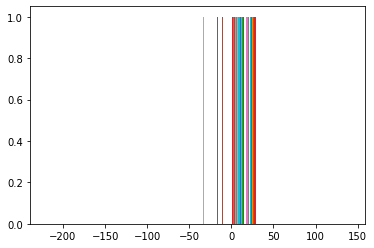

(array([   3.,    8.,    9.,   39., 1140.,   40.,   15.,    6.,    2.,
           2.]),
 array([-2864.26431857, -2213.25024261, -1562.23616665,  -911.22209069,
         -260.20801474,   390.80606122,  1041.82013718,  1692.83421314,
         2343.84828909,  2994.86236505,  3645.87644101]),
 <a list of 10 Patch objects>)

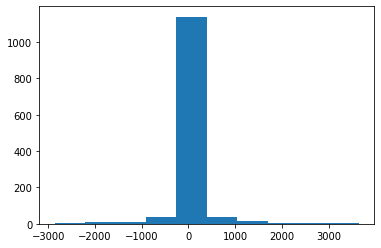

In [7]:
trials = 0
average_ML = 0
average_Data = 0
ML_samples = []
DM_samples = []
for i in range(len(X_test)):
    testImg = X_test[i]
    testLabel = Y_test[i]
    pred_real = gbr_real.predict([testImg]) + biasCrxn_real
    pred_imaginary = gbr_imaginary.predict([testImg]) + biasCrxn_imaginary
    if int(X_test[i][0]) == 9:# and int(X_test[i][1]):
        average_ML += pred_real
        average_Data += testLabel[0]
        ML_samples.append(pred_real)
        DM_samples.append(testLabel[0])
        trials += 1
print("Machine Learning average: ", average_ML / trials)
print("Data average: ", average_Data / trials)

plt.hist(ML_samples)
plt.show()
plt.hist(DM_samples)

## Prediction of c3pt conglomerate based on c2pt snapshot

In [ ]:
# features = np.array([np.array([ts[i], taus[i], xs[i], ys[i], zs[i], c2pt[i][0], c2pt[i][1]]) for i in range(len(ts))])
features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for f in features_unshifted:
    shift = int(f[0])
    features.append(np.roll(f[1:], -shift))

#### THIS IS WORSE ---> Try sparsely sampling features to combat large amount of data 
# for i in range(len(features)):
#     sparseSubFeature = np.array([features[i][j] for j in range(0, len(features[i]), 8)])
#     features[i] = sparseSubFeature

features = np.array(features)

labels = np.array([sum(c3pt[i:i+64][0]) / 64 for i in range(0, len(c3pt), 64)])

print(len(features), len(labels))
print(len(features[0]))

In [ ]:
labelFrac = 0.9
BCFrac = 0.05

labelEnd = int(len(labels) * labelFrac)
BCEnd    = int(len(labels) * (BCFrac + labelFrac))

X_train, Y_train, X_bc, Y_bc, X_test, Y_test = features[:labelEnd], labels[:labelEnd], features[labelEnd:BCEnd], labels[labelEnd:BCEnd], features[BCEnd:], labels[BCEnd:]

gbr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, max_depth=3)
gbr.fit(X_train, Y_train)

y_bc_pred = gbr.predict(X_bc)

biasCrxn = np.average(Y_bc - y_bc_pred)

In [ ]:
trials = 0
error = 0
raw_RMS = 0
for i in range(len(X_test)):
    testImg = X_test[i]
    testLabel = Y_test[i]
    pred = gbr.predict([testImg]) + biasCrxn
    error += abs(pred - testLabel)
    trials += 1
    
error /= trials
print(error / sum(abs(Y_test)) * len(Y_test))

## Train based on a NN rather than a Decision Tree

In [ ]:
# features = np.array([np.array([ts[i], taus[i], xs[i], ys[i], zs[i], c2pt[i][0], c2pt[i][1]]) for i in range(len(ts))])
features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for f in features_unshifted:
    shift = int(f[0])
    features.append(np.roll(f[1:], -shift))

#### Try sparsely sampling features to combat large amount of data 
# for i in range(len(features)):
#     sparseSubFeature = np.array([features[i][j] for j in range(0, len(features[i]), 8)])
#     features[i] = sparseSubFeature

features = np.array(features)

labels = np.array([sum(c3pt[i:i+64][0]) / 64 for i in range(0, len(c3pt), 64)])

print(len(features), len(labels))
print(len(features[0]))

In [ ]:
labelFrac = 0.9

labelEnd = int(len(labels) * labelFrac)

X_train, Y_train, X_test, Y_test = features[:labelEnd], labels[:labelEnd], features[labelEnd:], labels[labelEnd:]

mlp = MLPRegressor(max_iter=1000, learning_rate="adaptive", learning_rate_init=0.05)
mlp.fit(X_train, Y_train)

In [ ]:
trials = 0
error = 0
raw_RMS = 0
for i in range(len(X_test)):
    testImg = X_test[i]
    testLabel = Y_test[i]
    pred = mlp.predict([testImg])
    error += abs(pred - testLabel)
    trials += 1
    
error /= trials
print(error / sum(abs(Y_test)) * len(Y_test))